In [1]:
# from autoviz.AutoViz_Class import AutoViz_Class
# AV = AutoViz_Class()

import numpy as np
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from inspect_tables import (targhe, timestamp_names, plate_names,
                            veicoli, fatture, draw_date_relplot,
                            read_data, overview, draw_report, draw_correlation,
                            plot_date_relplot
                           )


import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 100
# sns.set_style("whitegrid")

%matplotlib inline

In [50]:
pd.DataFrame([["VISIONLINK", "Location", "No plate and no significant information"],
["VISIRUN", "CurrentPosition", "Tracking - Fully contained in FleetCurrentPosition"],
["VISIRUN", "CurrentPositionWithAddress", "Fully contained in CurrentPosition"],
["VISIRUN", "FleetCurrentPosition", "Tracking"],
["VISIRUN", "FleetCurrentPositionWithAddress", "Same as FleetCurrentPosition + address"],
["VISIRUN", "FleetKpi", ""],
["VISIRUN", "FleetOdometer", ""],
["VISIRUN", "KpiSummary", ""],
["VISIRUN", "RawTachoData", ""],
["VISIRUN", "RawTrackingData", ""],
["VISIRUN", "Route", ""],
["VISIRUN", "Stops", ""],],
             columns=["Fornitore", "API", "Description"]
            )

,Fornitore,API,Description
0,VISIONLINK,Location,No plate and no significant information
1,VISIRUN,CurrentPosition,Tracking - Fully contained in FleetCurrentPosi...
2,VISIRUN,CurrentPositionWithAddress,Fully contained in CurrentPosition
3,VISIRUN,FleetCurrentPosition,Tracking
4,VISIRUN,FleetCurrentPositionWithAddress,Same as FleetCurrentPosition + address
5,VISIRUN,FleetKpi,
6,VISIRUN,FleetOdometer,
7,VISIRUN,KpiSummary,
8,VISIRUN,RawTachoData,
9,VISIRUN,RawTrackingData,


# VISIRUN/CurrentPosition

In [3]:
df_CP = read_data("dataset/VISIRUN_CurrentPosition.csv")
# time_cols = [c for c in df_CP.columns if "date" in c.lower()]
# for c in time_cols:
#     df_CP[c] = pd.to_datetime(df_CP[c], errors='coerce')
df_CP.head()

,remoteUnitSerial,vehicleName,vehiclePlate,datestamp,vehicleCategory,timezone,lat,lon,workMinutes,statusCode,key,lastCommunicationDatetime,speed,odometer,heading,filename,plate,timestamp
0,60009121,CN433CA PIAGGIO,CN433CA,2021-04-27T08:56:56,Raimondi,Europe/Rome,44.699753,8.016591,132346.0,0.0,0.0,2021-04-27T08:56:56,0.0,74059763.0,67.03,2021-04-27-07,CN433CA,2021-04-27 08:56:56
1,60013442,CW365HC,CW365HC,2021-04-22T12:23:42,Cantiere La Spezia,Europe/Rome,45.960865,8.420048,188839.0,0.0,0.0,2021-04-25T12:04:12,0.0,25343610.0,231.28,2021-04-27-07,CW365HC,2021-04-22 12:23:42
2,60013445,CW368HC,CW368HC,2021-04-27T07:32:19,Cantiere La Spezia,Europe/Rome,45.716534,10.093649,160000.0,0.0,0.0,2021-04-27T08:37:55,0.0,23440240.0,127.25,2021-04-27-07,CW368HC,2021-04-27 07:32:19
3,60009121,CN433CA PIAGGIO,CN433CA,2021-04-27T10:01:28,Raimondi,Europe/Rome,44.678673,7.987436,132346.0,0.0,1.0,2021-04-27T10:01:28,33.4,74068039.0,58.04,2021-04-27-08,CN433CA,2021-04-27 10:01:28
4,60013442,CW365HC,CW365HC,2021-04-22T12:23:42,Cantiere La Spezia,Europe/Rome,45.960865,8.420048,188839.0,0.0,0.0,2021-04-25T12:04:12,0.0,25343610.0,231.28,2021-04-27-08,CW365HC,2021-04-22 12:23:42


---
## Overview

In [4]:
df_CP, _ = overview(df=df_CP)

    Dati raccolti tra 04/2021 e 09/2021 (con alcune eccezioni)

    18 parametri totali monitorati
    20990 record nel datalake
    14635 record non ripetuti
    12 truck di interesse monitorati
    In media 1749.1666666666667 misurazioni per ogni mezzo su 5 mesi
    In media 11.432461873638344 misurazioni/giorno/mezzo (dettaglio successivamente)
    85 fatture associate.

Misurazioni con valore singolo:
timezone      Europe/Rome
statusCode            0.0
Name: 0, dtype: object
--> Colonne eliminate


In [5]:
df_CP=df_CP[df_CP.timestamp.dt.year > 2020]

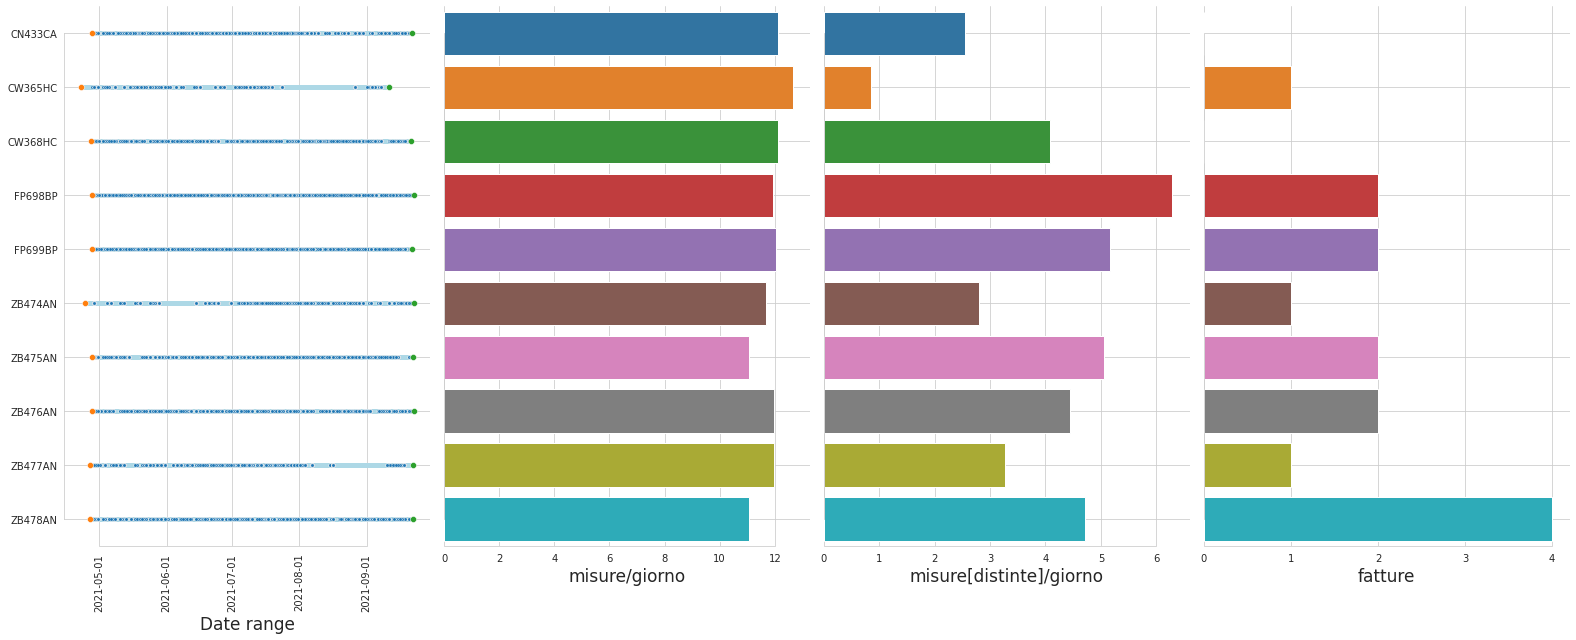

In [6]:
draw_report(df_CP)

In [7]:
df_CP = df_CP[df_CP.timestamp.dt.year==2021].drop(["filename", "lastCommunicationDatetime"], axis=1).drop_duplicates()

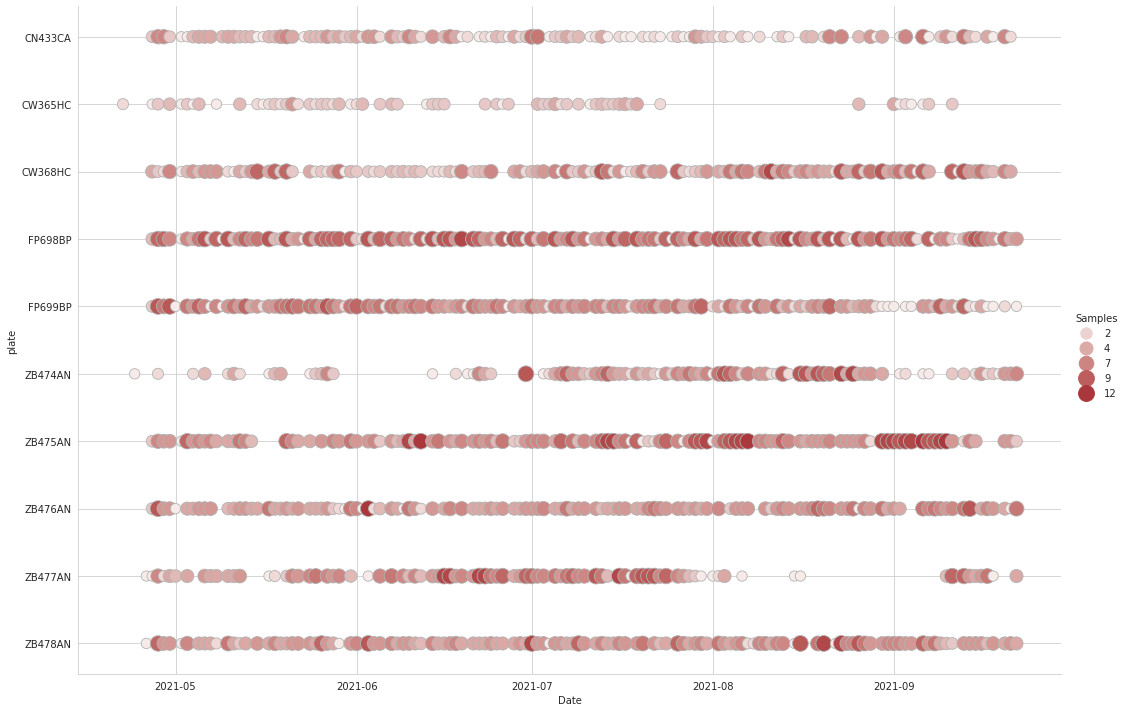

In [8]:
rl = draw_date_relplot(df_CP)

Text(0, 0.5, 'count')

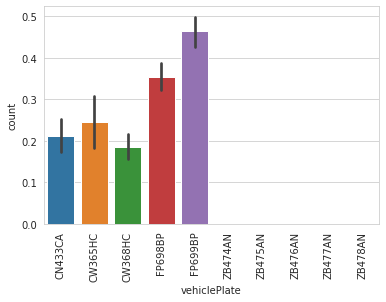

In [9]:
g = sns.barplot(data=df_CP, x="vehiclePlate", y="key")
g.tick_params(axis='x', rotation=90)
g.set_ylabel("count")

---
## Monotonia

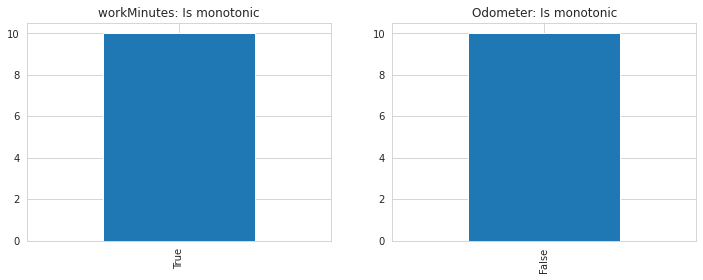

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
df_CP.groupby('vehiclePlate').workMinutes.apply(lambda x: x.is_monotonic_increasing).value_counts().sort_values(ascending=True).plot(kind="bar", title=f"workMinutes: Is monotonic", ax=ax[0])
df_CP.groupby('vehiclePlate').odometer.apply(lambda x: x.is_monotonic_increasing).value_counts().plot(kind="bar", title="Odometer: Is monotonic", ax=ax[1])
plt.show()

In [11]:
fig, ax = plt.subplots(figsize=(12,8), sharex=True)
# sns.lineplot(data=df_CP, x="datestamp", y="workMinutes", hue="vehiclePlate", ax=ax[0])
# sns.rugplot(data=df_CP, x="datestamp", hue="vehiclePlate", ax=ax[0])

sns.lineplot(data=df_CP, x="datestamp", y="odometer", hue="vehiclePlate", ax=ax)
sns.rugplot(data=df_CP, x="datestamp", hue="vehiclePlate", ax=ax)

for i, (vehiclePlate, d) in enumerate(df_CP.groupby('vehiclePlate')[["datestamp", "odometer"]]):
    d["df"] = d.odometer.diff().fillna(0)
    sns.scatterplot(data=d[d.df<0], x="datestamp", y="odometer", markers="*", s=50)
    plt.text(x=d[d.df<0].datestamp.values[0], y=d[d.df<0].odometer.values[0], s=str(d[d.df<0].df.values[0]))

fig.tight_layout()
# ax[1].get_legend().remove()

sns.despine(trim=True, left=True)
ax.legend(frameon=False, loc="center right", bbox_to_anchor=(1.1,0.5))
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f102ae49950> (for post_execute):


KeyboardInterrupt: 

---
## Correlation

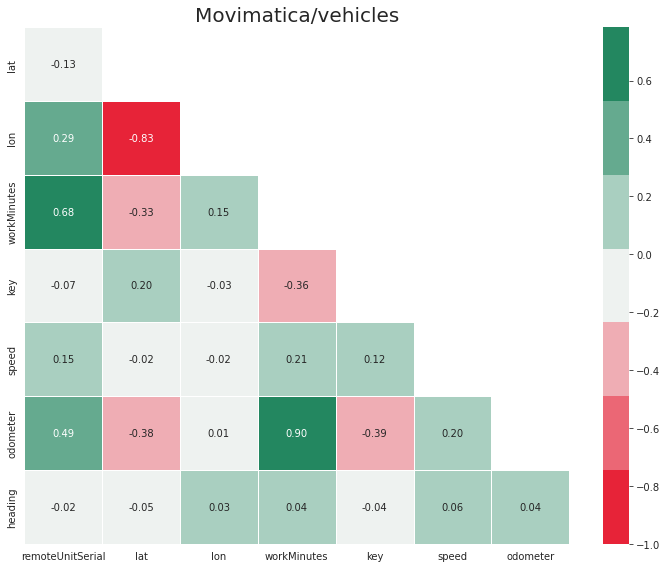

In [12]:
pseudo_plate = [c for c in df_CP.columns if len(df_CP[c].unique()) == 35]
correlations = df_CP.drop(pseudo_plate, axis=1).corr()

fig, ax = plt.subplots(figsize=(10,8))
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
heatmap = sns.heatmap(correlations.iloc[1:,:-1], annot=True, fmt='.2f', linewidths=0.5,
            mask=mask[1:,:-1], ax=ax, cmap=sns.diverging_palette(10, 150, s=90, n=7),
            robust=True, vmin=-1)#, annot_kws={"size": 10})
plt.title("Movimatica/vehicles", size=20)
plt.tight_layout()
# fig.savefig("corr.png")

---
# VISIRUN/FleetCurrentPosition

In [13]:
df_FC = read_data("dataset/VISIRUN_FleetCurrentPosition.csv")

/home/students/s265780/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [17]:
df_FC, _ = overview(df_FC)

    Dati raccolti tra 04/2021 e 09/2021 (con alcune eccezioni)

    18 parametri totali monitorati
    296548 record nel datalake
    62238 record non ripetuti
    17 truck di interesse monitorati
    In media 17444.0 misurazioni per ogni mezzo su 5 mesi
    In media 119.47945205479452 misurazioni/giorno/mezzo (dettaglio successivamente)
    140 fatture associate.

Misurazioni con valore singolo:
timezone      Europe/Rome
statusCode              0
Name: 0, dtype: object
--> Colonne eliminate


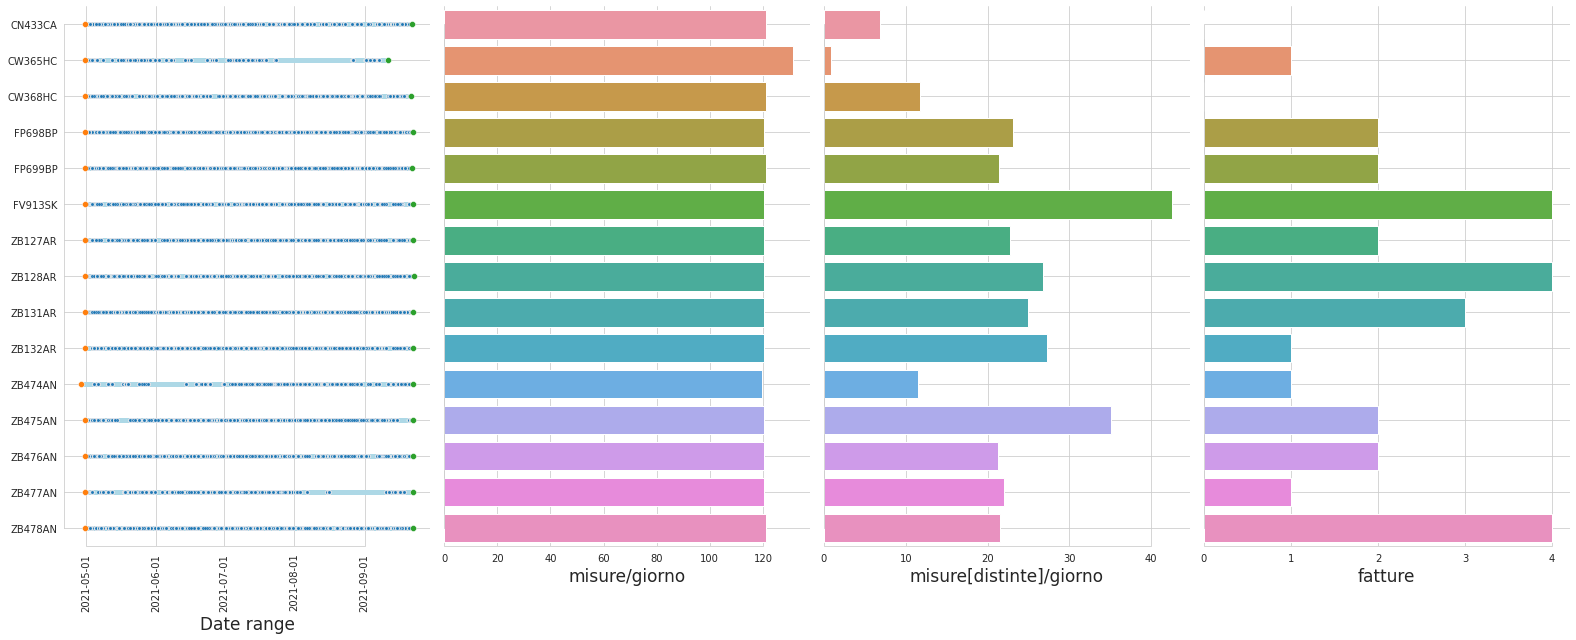

In [18]:
df_FC = df_FC[df_FC.timestamp.dt.year > 2020]
draw_report(df_FC)

In [19]:
df_FC = df_FC[df_FC.timestamp.dt.year==2021].drop(["filename", "lastCommunicationDatetime"], axis=1).drop_duplicates()

In [20]:
df_FC

,remoteUnitSerial,vehicleName,vehiclePlate,datestamp,vehicleCategory,lat,lon,workMinutes,key,speed,odometer,heading,plate,timestamp
0,60013442,CW365HC,CW365HC,2021-04-30T11:41:46,Cantiere La Spezia,45.958380,8.423066,188876,0,14.7,25376174.0,335.14,CW365HC,2021-04-30 11:41:46
1,60025915,ZB476AN Azimut 6,ZB476AN,2021-04-30T11:50:14,Roma,45.960163,8.420577,413337,0,0.0,106365018.0,337.76,ZB476AN,2021-04-30 11:50:14
2,60025946,FP698BP,FP698BP,2021-04-30T11:21:06,MONTE ISOLA,45.705685,10.095859,187492,0,0.0,41578064.0,269.59,FP698BP,2021-04-30 11:21:06
3,60025920,FP699BP,FP699BP,2021-04-30T11:49:48,MONTE ISOLA,45.717770,10.094360,267574,1,8.8,52437464.0,323.58,FP699BP,2021-04-30 11:49:48
4,60048783,FV913SK,FV913SK,2021-04-30T11:50:27,Cantiere Montale,43.854878,11.056219,22494,0,0.0,50447956.0,95.35,FV913SK,2021-04-30 11:50:27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296473,60039228,ZB128AR,ZB128AR,2021-09-22T15:45:42,Localizzatori Garda e Ledro,44.593100,7.928882,161054,0,21.0,72652669.0,235.82,ZB128AR,2021-09-22 15:45:42
296491,60039228,ZB128AR,ZB128AR,2021-09-22T15:50:30,Localizzatori Garda e Ledro,44.585785,7.905503,161054,0,50.6,72656003.0,214.55,ZB128AR,2021-09-22 15:50:30
296509,60039228,ZB128AR,ZB128AR,2021-09-22T15:55:42,Localizzatori Garda e Ledro,44.585075,7.902880,161054,0,0.0,72656252.0,202.94,ZB128AR,2021-09-22 15:55:42
296526,60039228,ZB128AR,ZB128AR,2021-09-22T16:00:46,Localizzatori Garda e Ledro,44.585110,7.902884,161054,0,0.0,72656252.0,4.28,ZB128AR,2021-09-22 16:00:46


In [21]:
tm1 = df_CP.set_index(["plate", "timestamp"]).sort_index()
tm2 = df_FC.set_index(["plate", "timestamp"]).sort_index()

print(tm1.shape, tm2.shape)

(6119, 13) (46728, 12)


In [39]:
pd.DataFrame([JN[c] for c in b]).T.all(1)

0        True
1        True
2       False
3       False
4        True
        ...  
3840     True
3841     True
3842     True
3843    False
3844     True
Length: 3845, dtype: bool

In [48]:
JN = df_CP.merge(df_FC, on=["plate", "timestamp"], suffixes=(None, "_fleet"))
JN.workMinutes = JN.workMinutes.astype(int)
for c in JN.drop(["plate", "timestamp", "Date"], axis=1).columns:
    if not c.endswith("_fleet"):
        JN[f"{c}_diff"] = JN[c] == JN[f"{c}_fleet"]

a = sum([[c[:-5], f"{c[:-5]}_fleet", f"{c}"] for c in JN.columns if c.endswith("_diff") and not JN[c].all()], [])
b = [c for c in JN.columns if c.endswith("_diff") and not JN[c].all()]

JN\
[a]\
[~pd.DataFrame([JN[c] for c in b]).T.all(1)]

,workMinutes,workMinutes_fleet,workMinutes_diff,key,key_fleet,key_diff,odometer,odometer_fleet,odometer_diff
2,132794,132893,False,0.0,0,True,74133765.0,74133770.0,False
3,132893,132794,False,0.0,0,True,74133770.0,74133765.0,False
6,188876,188943,False,0.0,0,True,25376174.0,25376170.0,False
7,188943,188876,False,0.0,0,True,25376170.0,25376174.0,False
13,413337,413714,False,0.0,0,True,106365018.0,106365230.0,False
...,...,...,...,...,...,...,...,...,...
3819,439446,439614,False,0.0,0,True,112633218.0,112633220.0,False
3820,439614,439446,False,0.0,0,True,112633220.0,112633218.0,False
3824,140715,140735,False,0.0,0,True,75605772.0,75605770.0,False
3825,140735,140715,False,0.0,0,True,75605770.0,75605772.0,False


In [61]:
tm2.shape, tm2.drop_duplicates().shape

((62235, 14), (62235, 14))

---
# VISIRUN/FleetCurrentPositionWithAddress

In [57]:
df_FCA = read_data("dataset/VISIRUN_FleetCurrentPositionWithAddress.csv")

/home/students/s265780/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [58]:
df_FCA, _ = overview(df_FCA)

    Dati raccolti tra 04/2021 e 09/2021 (con alcune eccezioni)

    19 parametri totali monitorati
    249475 record nel datalake
    58535 record non ripetuti
    17 truck di interesse monitorati
    In media 14675.0 misurazioni per ogni mezzo su 5 mesi
    In media 100.51369863013699 misurazioni/giorno/mezzo (dettaglio successivamente)
    140 fatture associate.

Misurazioni con valore singolo:
timezone      Europe/Rome
statusCode              0
Name: 0, dtype: object
--> Colonne eliminate


In [59]:
df_FCA = df_FCA[df_FCA.timestamp.dt.year==2021].drop(["lastCommunicationDatetime"], axis=1).drop_duplicates()

In [66]:
JN

,remoteUnitSerial,vehicleName,vehiclePlate,datestamp,vehicleCategory,lat,lon,workMinutes,key,address,speed,odometer,heading,filename,plate,timestamp,remoteUnitSerial_addr,vehicleName_addr,vehiclePlate_addr,datestamp_addr,vehicleCategory_addr,lat_addr,lon_addr,workMinutes_addr,key_addr,speed_addr,odometer_addr,heading_addr,remoteUnitSerial_diff,vehicleName_diff,vehiclePlate_diff,datestamp_diff,vehicleCategory_diff,lat_diff,lon_diff,workMinutes_diff,key_diff,speed_diff,odometer_diff,heading_diff
0,60013442,CW365HC,CW365HC,2021-04-30T11:41:46,Cantiere La Spezia,45.958380,8.423066,188876,0,"Via Alfredo Di Dio, 186-215, 28877 Ornavasso V...",14.7,25376174.0,335.14,2021-04-30-10-52,CW365HC,2021-04-30 11:41:46,60013442,CW365HC,CW365HC,2021-04-30T11:41:46,Cantiere La Spezia,45.958380,8.423066,188876,0,14.7,25376174.0,335.14,True,True,True,True,True,True,True,True,True,True,True,True
1,60013442,CW365HC,CW365HC,2021-04-30T11:41:46,Cantiere La Spezia,45.958380,8.423066,188876,0,"Via Alfredo Di Dio, 186-215, 28877 Ornavasso V...",14.7,25376174.0,335.14,2021-04-30-10-52,CW365HC,2021-04-30 11:41:46,60013442,CW365HC,CW365HC,2021-04-30T11:41:46,Cantiere La Spezia,45.958380,8.423066,188943,0,14.7,25376170.0,335.14,True,True,True,True,True,True,True,False,True,True,False,True
2,60013442,CW365HC,CW365HC,2021-04-30T11:41:46,Cantiere La Spezia,45.958380,8.423066,188876,0,"Via Alfredo Di Dio, 186-215, 28877 Ornavasso V...",14.7,25376174.0,335.14,2021-04-30-10-57,CW365HC,2021-04-30 11:41:46,60013442,CW365HC,CW365HC,2021-04-30T11:41:46,Cantiere La Spezia,45.958380,8.423066,188876,0,14.7,25376174.0,335.14,True,True,True,True,True,True,True,True,True,True,True,True
3,60013442,CW365HC,CW365HC,2021-04-30T11:41:46,Cantiere La Spezia,45.958380,8.423066,188876,0,"Via Alfredo Di Dio, 186-215, 28877 Ornavasso V...",14.7,25376174.0,335.14,2021-04-30-10-57,CW365HC,2021-04-30 11:41:46,60013442,CW365HC,CW365HC,2021-04-30T11:41:46,Cantiere La Spezia,45.958380,8.423066,188943,0,14.7,25376170.0,335.14,True,True,True,True,True,True,True,False,True,True,False,True
4,60013442,CW365HC,CW365HC,2021-04-30T11:41:46,Cantiere La Spezia,45.958380,8.423066,188876,0,"Via Alfredo Di Dio, 186-215, 28877 Ornavasso V...",14.7,25376174.0,335.14,2021-04-30-11-02,CW365HC,2021-04-30 11:41:46,60013442,CW365HC,CW365HC,2021-04-30T11:41:46,Cantiere La Spezia,45.958380,8.423066,188876,0,14.7,25376174.0,335.14,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259438,60025915,ZB476AN Azimut 6,ZB476AN,2021-09-22T15:11:53,Roma,45.960163,8.420420,452089,0,"Via Alfredo Di Dio, 190-194, 28877 Ornavasso V...",0.0,114580637.0,89.11,2021-09-22-13-52,ZB476AN,2021-09-22 15:11:53,60025915,ZB476AN Azimut 6,ZB476AN,2021-09-22T15:11:53,Roma,45.960163,8.420420,452089,0,0.0,114580637.0,89.11,True,True,True,True,True,True,True,True,True,True,True,True
259439,60025915,ZB476AN Azimut 6,ZB476AN,2021-09-22T15:11:53,Roma,45.960163,8.420420,452089,0,"Via Alfredo Di Dio, 190-194, 28877 Ornavasso V...",0.0,114580637.0,89.11,2021-09-22-13-57,ZB476AN,2021-09-22 15:11:53,60025915,ZB476AN Azimut 6,ZB476AN,2021-09-22T15:11:53,Roma,45.960163,8.420420,452089,0,0.0,114580637.0,89.11,True,True,True,True,True,True,True,True,True,True,True,True
259440,60025915,ZB476AN Azimut 6,ZB476AN,2021-09-22T15:11:53,Roma,45.960163,8.420420,452089,0,"Via Alfredo Di Dio, 190-194, 28877 Ornavasso V...",0.0,114580637.0,89.11,2021-09-22-14-02,ZB476AN,2021-09-22 15:11:53,60025915,ZB476AN Azimut 6,ZB476AN,2021-09-22T15:11:53,Roma,45.960163,8.420420,452089,0,0.0,114580637.0,89.11,True,True,True,True,True,True,True,True,True,True,True,True
259441,60025915,ZB476AN Azimut 6,ZB476AN,2021-09-22T15:11:53,Roma,45.960163,8.420420,452089,0,"Via Alfredo Di Dio, 190-194, 28877 Ornavasso V...",0.0,114580637.0,89.11,2021-09-22-14-07,ZB476AN,2021-09-22 15:11:53,60025915,ZB476AN Azimut 6,ZB4

In [65]:
JN = df_FCA.merge(df_FC, on=["plate", "timestamp"], suffixes=(None, "_addr"))
JN.workMinutes = JN.workMinutes.astype(int)
for c in JN.drop(["plate", "timestamp", "address", "filename", "remoteUnitSerial_addr"], axis=1).columns:
    if not c.endswith("_fleet"):
        JN[f"{c}_diff"] = JN[c] == JN[f"{c}_addr"]

a = sum([[c[:-5], f"{c[:-5]}_addr", f"{c}"] for c in JN.columns if c.endswith("_diff") and not JN[c].all()], [])
b = [c for c in JN.columns if c.endswith("_diff") and not JN[c].all()]

JN\
[a]\
[~pd.DataFrame([JN[c] for c in b]).T.all(1)]

KeyError: 'vehicleName_addr_addr'

---
# FleetOdometer

In [70]:
df_FO = pd.read_csv("dataset/VISIRUN_FleetOdometer.csv", index_col=0)#.drop("filename", axis=1)
df_FO = df_FO[df_FO.plate.isin(targhe)]
df_FO["timestamp"] = pd.to_datetime(df_FO.filename, format="%Y-%m-%d-%H-%M")
df_FO.odometer = df_FO.odometer.astype(float)
df_FO

/home/students/s265780/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,remoteUnitSerial,vehicleName,plate,odometer,engineOnTime,filename,timestamp
3,60013442,CW365HC,CW365HC,25376.17,3149:03,2021-04-30-12-44,2021-04-30 12:44:00
9,60025915,ZB476AN Azimut 6,ZB476AN,106365.02,6894:17,2021-04-30-12-44,2021-04-30 12:44:00
26,60025946,FP698BP,FP698BP,41585.45,3126:41,2021-04-30-12-44,2021-04-30 12:44:00
30,60025920,FP699BP,FP699BP,52440.60,4464:18,2021-04-30-12-44,2021-04-30 12:44:00
33,60048783,FV913SK,FV913SK,50459.60,381:02,2021-04-30-12-44,2021-04-30 12:44:00
...,...,...,...,...,...,...,...
100,60039228,ZB128AR,ZB128AR,72656.28,2691:37,2021-09-22-14-10,2021-09-22 14:10:00
103,60025969,ZB475AN Azimut 6,ZB475AN,112655.11,7328:34,2021-09-22-14-10,2021-09-22 14:10:00
111,60009121,CN433CA PIAGGIO,CN433CA,75605.77,2345:35,2021-09-22-14-10,2021-09-22 14:10:00
119,60025960,ZB474AN Azimut 6,ZB474AN,105201.32,6501:33,2021-09-22-14-10,2021-09-22 14:10:00


In [71]:
df_FO, _ = overview(df_FO, fatture=fatture)

    Dati raccolti tra 04/2021 e 09/2021
    7 parametri totali monitorati
    273462 record nel datalake
    273462 record non ripetuti
    17 truck monitorati
    In media 16086.0 misurazioni per ogni mezzo su 5 mesi
    In media 110.93793103448276 misurazioni/giorno/mezzo (dettaglio successivamente)
    140 fatture associate.

Misurazioni con valore singolo:
Series([], Name: 3, dtype: float64)
--> Colonne eliminate


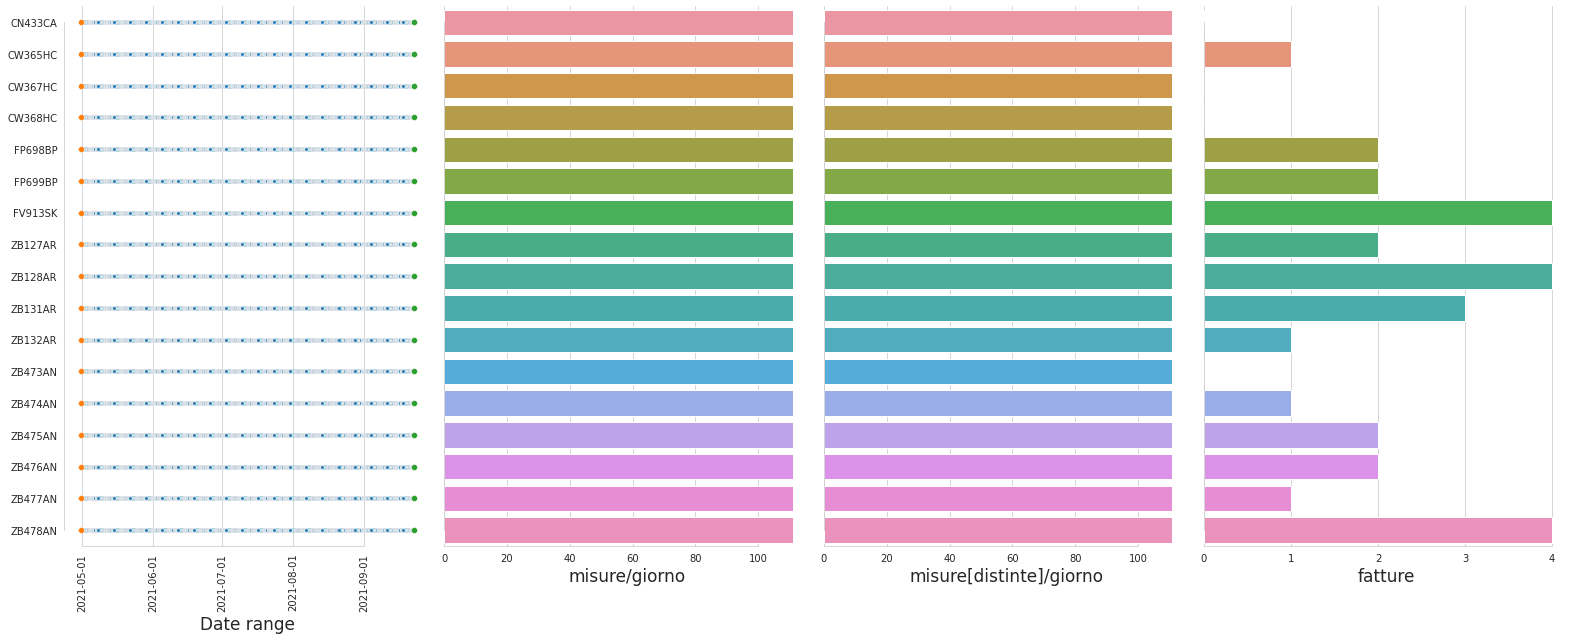

In [72]:
draw_report(df_FO, fatture=fatture, per_day=True)

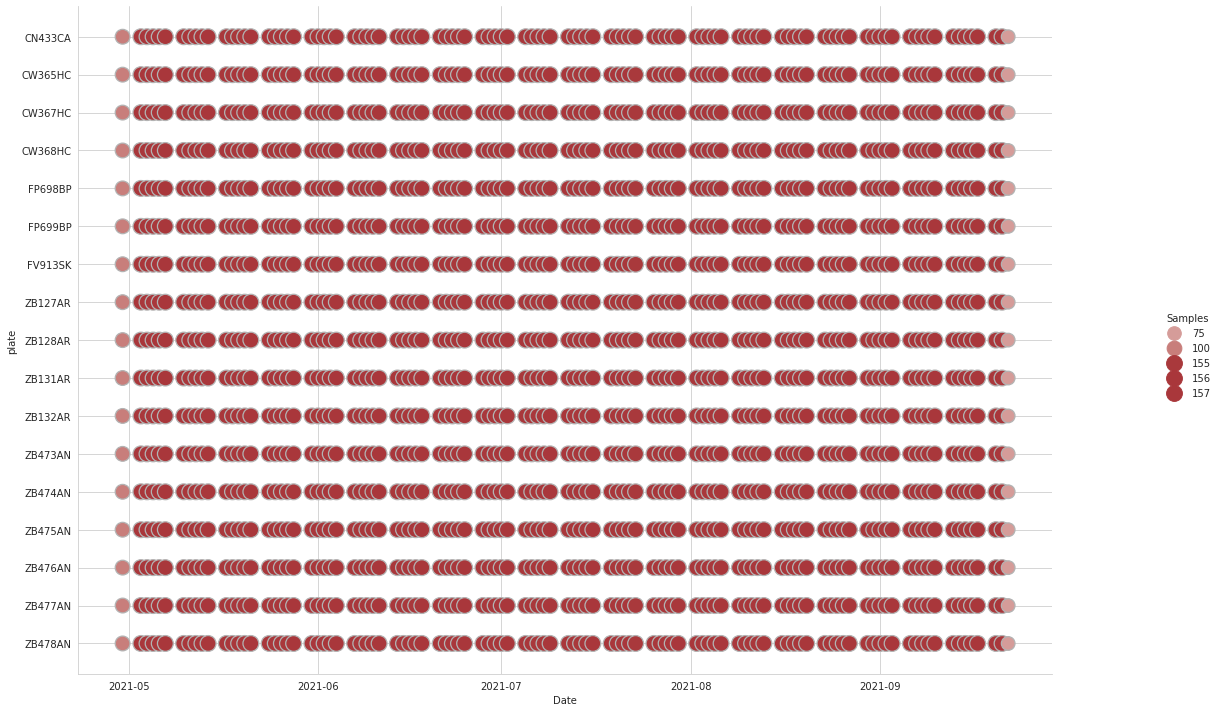

In [73]:
plot_date_relplot(df_FO, plate="plate")

In [74]:
df_FO = df_FO.drop(["Date", "filename"], axis=1).set_index("timestamp").drop_duplicates().reset_index()

### Monotonia

In [75]:
df_FO[df_FO.plate.isin(['CW365HC', 'ZB476AN', 'FP698BP', 'FP699BP', 'FV913SK', 'CW368HC'])].sample(frac=0.01)

,timestamp,remoteUnitSerial,vehicleName,plate,odometer,engineOnTime
28935,2021-08-25 12:30:00,60025915,ZB476AN Azimut 6,ZB476AN,113558.94,7421:36
13442,2021-06-29 11:45:00,60048783,FV913SK,FV913SK,54355.05,741:36
25957,2021-08-16 08:00:00,60025946,FP698BP,FP698BP,46015.33,3452:55
21956,2021-07-29 09:40:00,60025946,FP698BP,FP698BP,45000.54,3380:16
29891,2021-08-30 09:30:00,60025946,FP698BP,FP698BP,46834.71,3508:05
...,...,...,...,...,...,...
9311,2021-06-11 10:35:00,60025920,FP699BP,FP699BP,54273.22,4622:45
15449,2021-07-06 08:40:00,60013442,CW365HC,CW365HC,25464.71,3184:30
7301,2021-06-03 14:10:00,60025915,ZB476AN Azimut 6,ZB476AN,108192.13,7045:35
12237,2021-06-24 09:10:00,60048783,FV913SK,FV913SK,54022.24,714:26


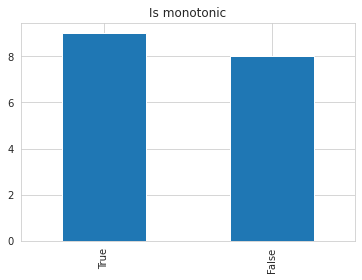

In [102]:
g = df_FO.groupby('plate').odometer.apply(lambda x: x.is_monotonic_increasing).value_counts().plot(kind="bar", title="Is monotonic")

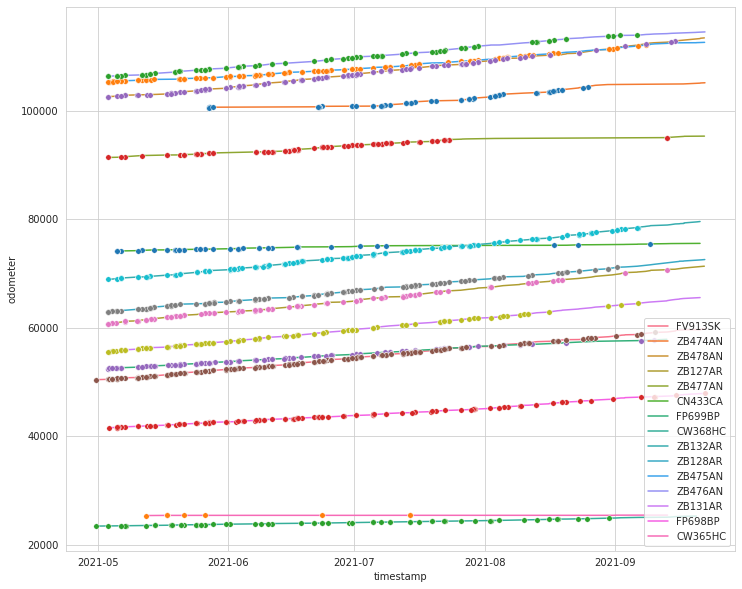

In [99]:
tmp = df_FO.sample(frac=0.1)
# tmp = df_FO[df_FO.plate.isin(['FP698BP'])].sample(frac=0.1)

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(data=tmp,
             x="timestamp", y="odometer", hue="plate", ax=ax, zorder=1)
ax.legend(frameon=False, loc="center right", bbox_to_anchor=(1.2,.5))
# ax.set_yscale('log')

for i, (plate, d) in enumerate(tmp.groupby('plate')[["timestamp", "odometer"]]):
    d["df"] = d.odometer.diff().fillna(0)
    sns.scatterplot(data=d[d.df<0], x="timestamp", y="odometer", markers="*", s=30, zorder=2)
#     plt.text(x=d[d.df<0].timestamp.values[0], y=d[d.df<0].odometer.values[0], s=str(d[d.df<0].df.values[0]))

## RawTachodata

In [45]:
df_tacho = pd.read_csv("dataset/VISIRUN_RawTachoData.csv", index_col=0)


In [49]:
pd.read_csv("dataset/VISIRUN_KpiSummary.csv", index_col=0).drop("filename", axis=1).drop_duplicates()

,driveTime,workTime,idleTime,stopTime,distance,consumption,wastedFuel,timestampCall
0,139:55,220:45,80:49,570:36,2839293,455,158,2021-05-03 09:08:45.473678100+00:00
0,140:32,221:45,81:12,571:04,2856089,459,162,2021-05-03 09:10:00.268153500+00:00
0,142:45,224:42,81:56,574:02,2916668,463,164,2021-05-03 09:15:00.212408400+00:00
0,144:55,227:50,82:55,576:49,2981995,471,166,2021-05-03 09:20:00.306529200+00:00
0,146:41,230:31,83:49,580:03,3035573,477,166,2021-05-03 09:25:00.199093800+00:00
...,...,...,...,...,...,...,...,...
0,166:56,257:26,90:30,835:03,4303189,723,274,2021-09-22 13:50:00.247766200+00:00
0,167:20,258:14,90:54,840:00,4322945,728,274,2021-09-22 13:55:00.263224200+00:00
0,167:46,259:22,91:36,844:37,4341837,740,275,2021-09-22 14:00:00.561962200+00:00
0,168:22,259:52,91:30,849:52,4361978,745,278,2021-09-22 14:05:00.506258900+00:00


In [54]:
df_kpisumm = pd.read_csv("dataset/VISIRUN_KpiSummary.csv", index_col=0).drop("filename", axis=1).reset_index(drop=True)

df_kpisumm.timestampCall = pd.to_datetime(df_kpisumm.timestampCall, format="%Y-%m-%d %H:%M:%S.%f%z", utc=True)

df_kpisumm

,driveTime,workTime,idleTime,stopTime,distance,consumption,wastedFuel,timestampCall
0,139:55,220:45,80:49,570:36,2839293,455,158,2021-05-03 09:08:45.473678100+00:00
1,140:32,221:45,81:12,571:04,2856089,459,162,2021-05-03 09:10:00.268153500+00:00
2,142:45,224:42,81:56,574:02,2916668,463,164,2021-05-03 09:15:00.212408400+00:00
3,144:55,227:50,82:55,576:49,2981995,471,166,2021-05-03 09:20:00.306529200+00:00
4,146:41,230:31,83:49,580:03,3035573,477,166,2021-05-03 09:25:00.199093800+00:00
...,...,...,...,...,...,...,...,...
40873,166:56,257:26,90:30,835:03,4303189,723,274,2021-09-22 13:50:00.247766200+00:00
40874,167:20,258:14,90:54,840:00,4322945,728,274,2021-09-22 13:55:00.263224200+00:00
40875,167:46,259:22,91:36,844:37,4341837,740,275,2021-09-22 14:00:00.561962200+00:00
40876,168:22,259:52,91:30,849:52,4361978,745,278,2021-09-22 14:05:00.506258900+00:00


In [65]:
pd.to_datetime(df_kpisumm.driveTime, format="%M:$S")

ValueError: time data '139:55' does not match format '%M:$S' (match)